# Crop Pest Detection Model

This notebook trains a MobileNetV3-based pest classifier using transfer learning on a Pest Dataset with 9 Classes.

It's designed to:
- Classify crop pest images into multiple categories
- Support incremental retraining with new data
- Provide confidence scores with predictions
- Be easily integrated into web APIs or mobile applications


**Dataset:** [Pest Dataset](https://www.kaggle.com/datasets/simranvolunesia/pest-dataset)

In [1]:
# Install required packages
!pip install -q tensorflow numpy pandas matplotlib seaborn scikit-learn pillow

print("✓ Packages installed successfully")

✓ Packages installed successfully


## 2. Setup Directories

Configure paths for Kaggle environment.

In [2]:
import os
from pathlib import Path
import kagglehub

# ==========================================================
# DOWNLOAD DATASET USING KAGGLE HUB (Colab-friendly)
# ==========================================================
print("="*60)
print("DOWNLOADING DATASET USING KAGGLEHUB")
print("="*60)

# This will download the dataset to /root/.cache/kagglehub/...
DATASET_ROOT = kagglehub.dataset_download("simranvolunesia/pest-dataset")
print(f"Dataset downloaded to: {DATASET_ROOT}\n")

# ==========================================================
# SET PATHS (mirror original Kaggle structure)
# ==========================================================
# Dataset extracted folder
KAGGLE_INPUT = DATASET_ROOT

# Usually the dataset contains "pest/train" & "pest/test".
# Adjust if needed:
TRAIN_DIR = os.path.join(KAGGLE_INPUT, "pest", "train")
TEST_DIR = os.path.join(KAGGLE_INPUT, "pest", "test")

# Working & model directories (Colab equivalent)
WORKING_DIR = "/content"
MODELS_DIR = os.path.join(WORKING_DIR, "models")

# Create models directory
os.makedirs(MODELS_DIR, exist_ok=True)

# ==========================================================
# VERIFY DATASET STRUCTURE
# ==========================================================
print("="*60)
print("COLAB ENVIRONMENT SETUP (KaggleHub)")
print("="*60)
print(f"Dataset Root:   {KAGGLE_INPUT}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Test Directory:  {TEST_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print()

# Check if dataset exists
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    print("✓ Dataset found successfully!")
    print(f"  Train classes: {len(os.listdir(TRAIN_DIR))}")
    print(f"  Test classes:  {len(os.listdir(TEST_DIR))}")
else:
    print("⚠ Dataset not found!")
    print("\nVerify the folder structure inside the downloaded dataset:")
    print("Expected:")
    print("  pest/train/<classes>")
    print("  pest/test/<classes>")
    raise FileNotFoundError("Dataset not in expected format.")

print("="*60)

DOWNLOADING DATASET USING KAGGLEHUB


100%|██████████| 69.5M/69.5M [00:00<00:00, 89.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1

COLAB ENVIRONMENT SETUP (KaggleHub)
Dataset Root:   /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1
Train Directory: /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1/pest/train
Test Directory:  /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1/pest/test
Models Directory: /content/models

✓ Dataset found successfully!
  Train classes: 9
  Test classes:  9


## 3. Data Exploration

Explore the dataset structure and visualize sample images.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Count images per class
def count_images_in_dir(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]
            counts[class_name] = len(image_files)
    return counts

# Use TRAIN_DIR and TEST_DIR from previous KaggleHub cell
train_counts = count_images_in_dir(TRAIN_DIR)
test_counts = count_images_in_dir(TEST_DIR)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTotal classes: {len(train_counts)}")
print(f"Total training images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")
print(f"\nClass distribution:")
for class_name in sorted(train_counts.keys()):
    print(f"  {class_name:20s}: {train_counts[class_name]:4d} train, {test_counts.get(class_name, 0):4d} test")
print("="*60)


DATASET SUMMARY

Total classes: 9
Total training images: 2700
Total test images: 450

Class distribution:
  aphids              :  300 train,   50 test
  armyworm            :  300 train,   50 test
  beetle              :  300 train,   50 test
  bollworm            :  300 train,   50 test
  grasshopper         :  300 train,   50 test
  mites               :  300 train,   50 test
  mosquito            :  300 train,   50 test
  sawfly              :  300 train,   50 test
  stem_borer          :  300 train,   50 test


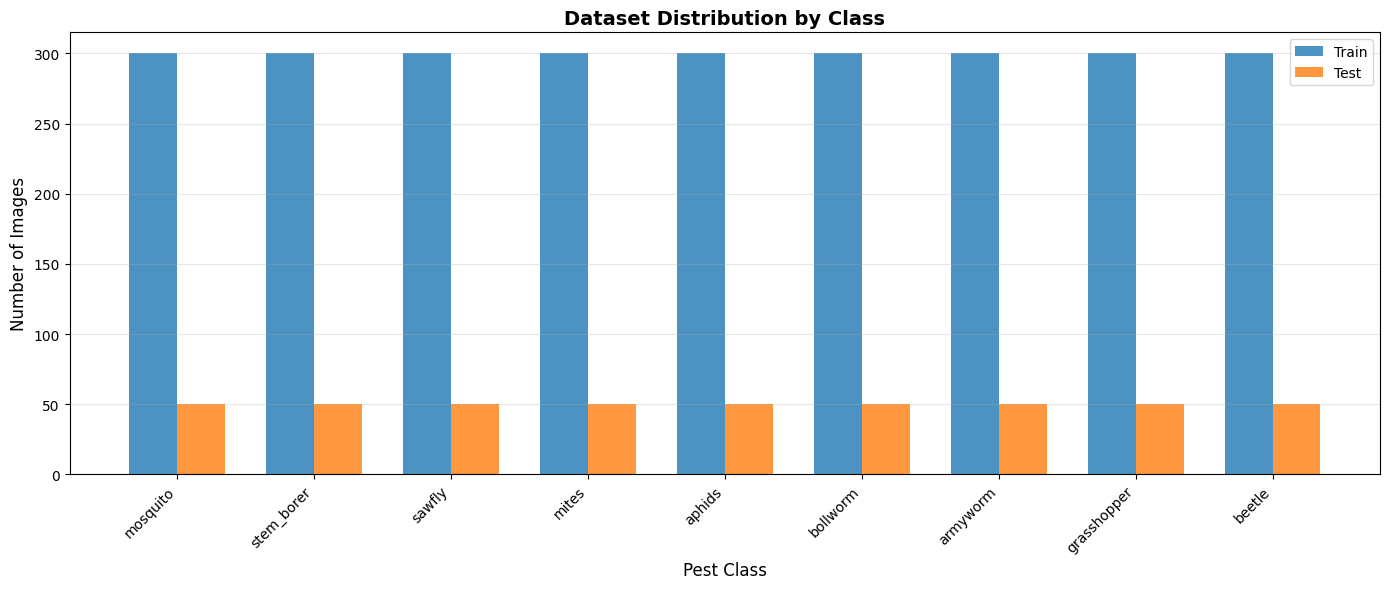

In [4]:
# Visualizing class distribution
import pandas as pd
import seaborn as sns

plt.figure(figsize=(14, 6))

# Create dataframe
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Test': [test_counts.get(c, 0) for c in train_counts.keys()]
})

# Plot
df_counts_sorted = df_counts.sort_values('Train', ascending=False)
x = np.arange(len(df_counts_sorted))
width = 0.35

plt.bar(x - width/2, df_counts_sorted['Train'], width, label='Train', alpha=0.8)
plt.bar(x + width/2, df_counts_sorted['Test'], width, label='Test', alpha=0.8)

plt.xlabel('Pest Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
plt.xticks(x, df_counts_sorted['Class'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

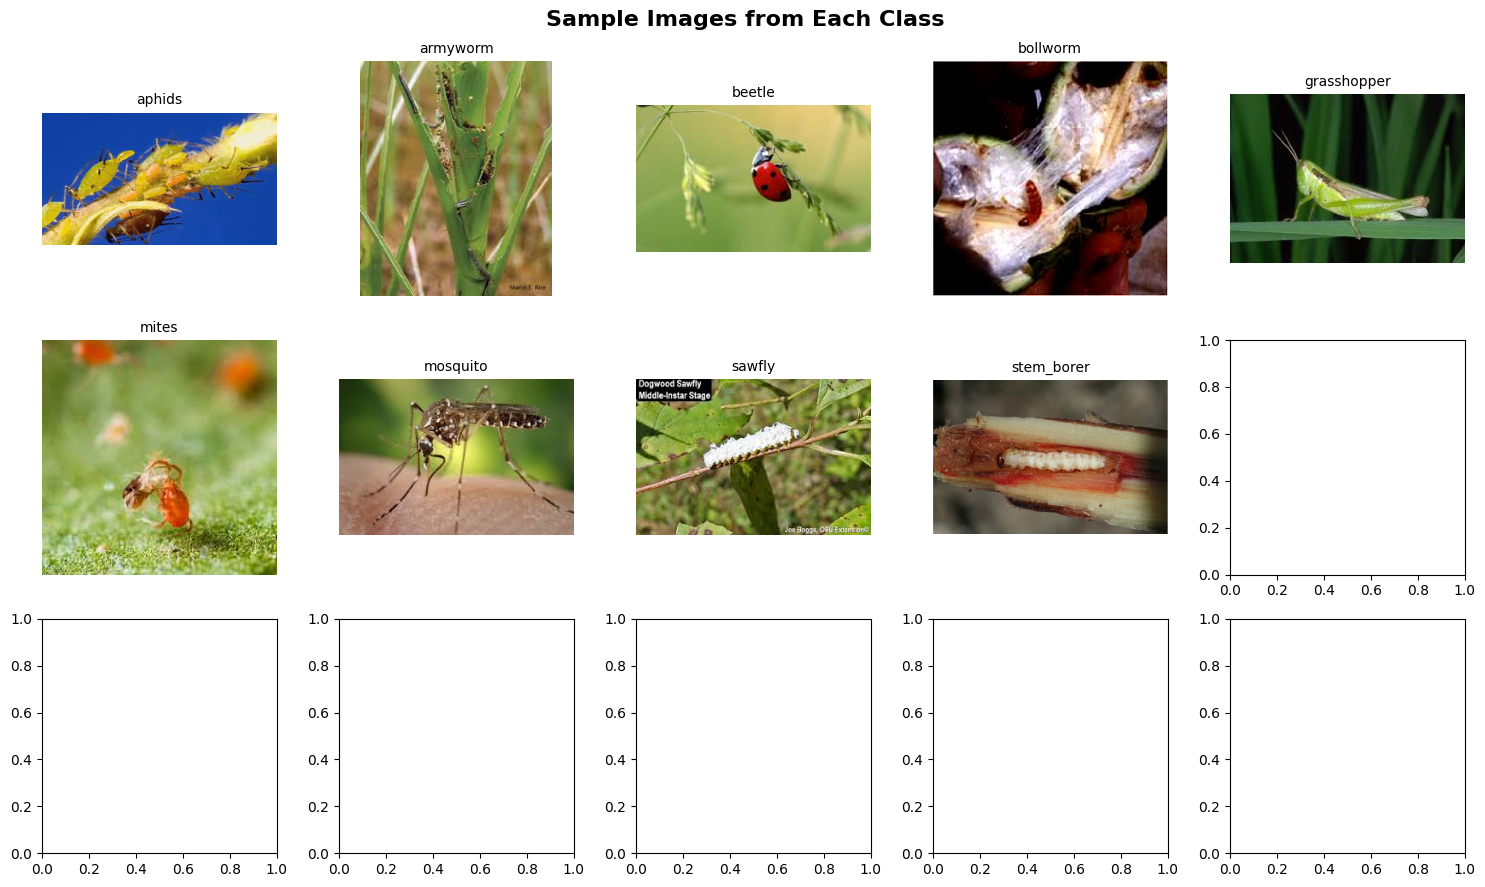

In [5]:
# Visualizing sample images from each class
class_names = sorted(train_counts.keys())
num_classes = len(class_names)

fig, axes = plt.subplots(3, min(5, num_classes), figsize=(15, 9))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(class_names[:15]):  # Show max 15 classes
    row = idx // 5
    col = idx % 5

    class_dir = os.path.join(TRAIN_DIR, class_name)
    images = [f for f in os.listdir(class_dir)
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    if images:
        img_path = os.path.join(class_dir, images[0])
        img = Image.open(img_path)

        if num_classes <= 5:
            axes[col].imshow(img)
            axes[col].set_title(class_name, fontsize=10)
            axes[col].axis('off')
        else:
            axes[row, col].imshow(img)
            axes[row, col].set_title(class_name, fontsize=10)
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Set up data generators with augmentation for training.

In [6]:
# Defining DataPreprocessor for Kaggle - Enhanced version with improved augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class DataPreprocessor:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size

    def create_train_generator(self):
        """Enhanced data augmentation matching food classification best practices"""
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=20,              # Standardized to 20 degrees
            width_shift_range=0.2,           # Standardized shift range
            height_shift_range=0.2,          # Standardized shift range
            shear_range=0.2,                 # Standardized shear
            zoom_range=0.2,                  # Standardized zoom
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )

    def create_test_generator(self):
        return ImageDataGenerator(preprocessing_function=preprocess_input)

    def load_train_data(self, train_dir):
        train_datagen = self.create_train_generator()
        train_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', subset='training', shuffle=True
        )
        val_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', subset='validation', shuffle=True
        )
        return train_gen, val_gen

    def load_test_data(self, test_dir):
        test_datagen = self.create_test_generator()
        return test_datagen.flow_from_directory(
            test_dir, target_size=self.img_size, batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )

print("✓ Enhanced DataPreprocessor ready with optimized augmentation")

✓ Enhanced DataPreprocessor ready with optimized augmentation


In [7]:
# Initialize preprocessor
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

preprocessor = DataPreprocessor(img_size=IMG_SIZE, batch_size=BATCH_SIZE)

# Load data
print("Loading training and validation data...")
train_generator, validation_generator = preprocessor.load_train_data(TRAIN_DIR)

print("\nLoading test data...")
test_generator = preprocessor.load_test_data(TEST_DIR)

# Get class information
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"\n✓ Data loaded successfully!")
print(f"  Classes: {num_classes}")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"\n  Class names: {class_names}")

Loading training and validation data...
Found 2160 images belonging to 9 classes.
Found 540 images belonging to 9 classes.

Loading test data...
Found 450 images belonging to 9 classes.

✓ Data loaded successfully!
  Classes: 9
  Training samples: 2160
  Validation samples: 540
  Test samples: 450

  Class names: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


Visualizing data augmentation...


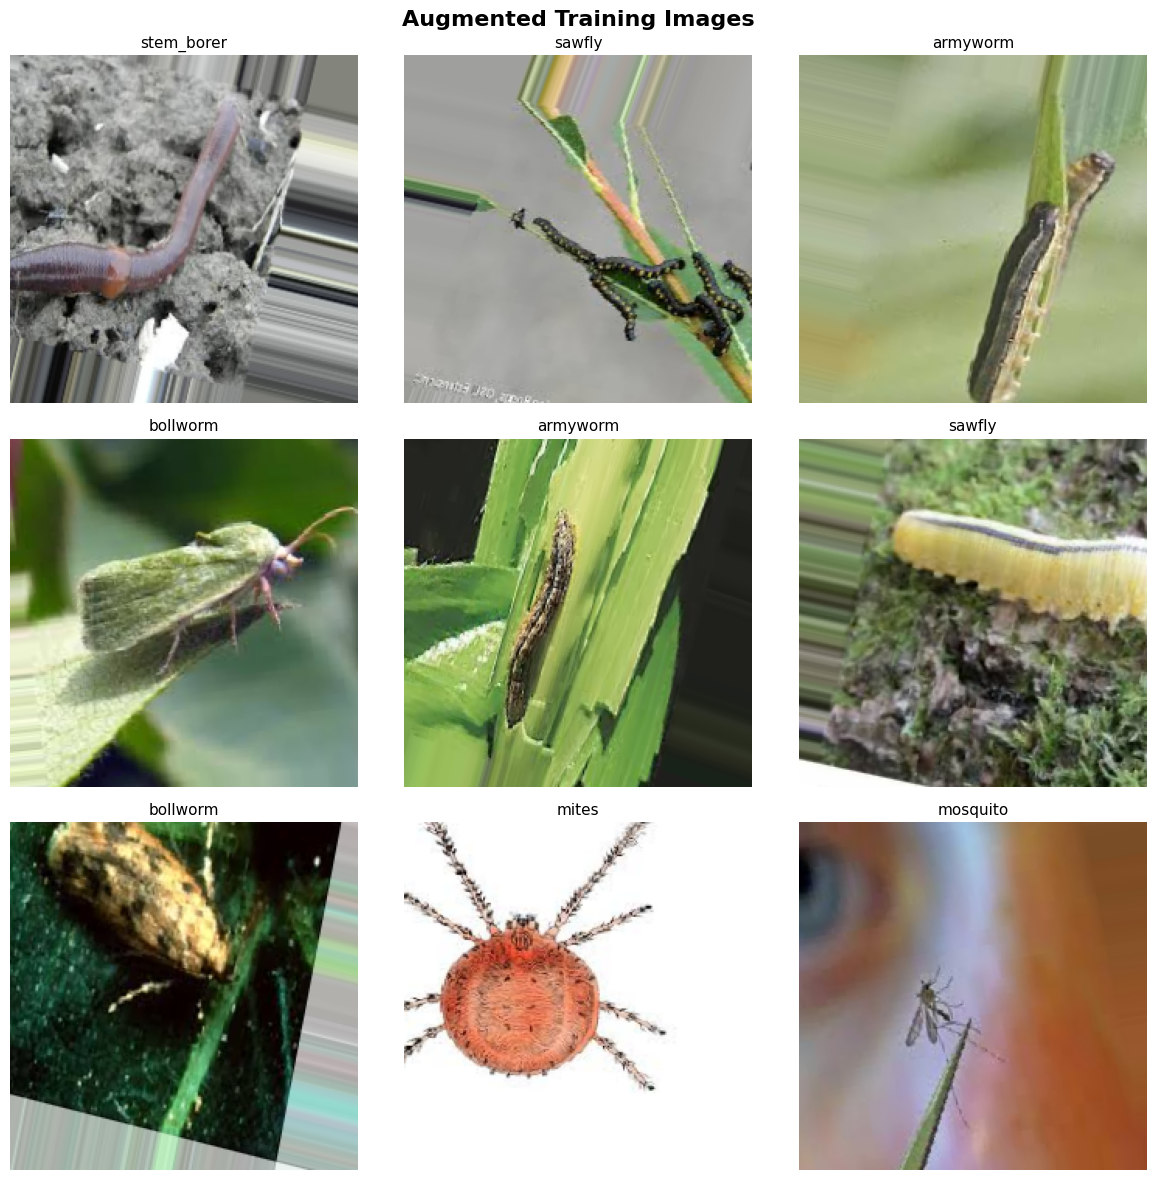

In [8]:
# Visualize augmented images
print("Visualizing data augmentation...")

# Get a batch of images
sample_batch = next(train_generator)
sample_images = sample_batch[0][:9]
sample_labels = sample_batch[1][:9]

# Denormalize images for display
def denormalize_image(img):
    img = img.copy()
    img += 1
    img *= 127.5
    return np.clip(img, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        img = denormalize_image(sample_images[i])
        label_idx = np.argmax(sample_labels[i])
        label = class_names[label_idx]

        ax.imshow(img)
        ax.set_title(label, fontsize=11)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Model Development

Build MobileNetV3-based classifier with transfer learning.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Build model with improved architecture matching food classification design
def build_mobilenet_classifier(num_classes, img_size=(224, 224)):
    """
    Build improved MobileNetV2-based classifier with food classification architecture.
    Key improvements:
    - BatchNormalization after each dense layer
    - Optimized dropout rates (0.5, 0.3, 0.2)
    - Two dense layers (512, 256) for better feature learning
    """
    # Load MobileNetV2 with ImageNet weights
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3)
    )

    # Freeze base model
    base_model.trainable = False

    # Build improved model with BatchNormalization
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
print(f"\nBuilding improved model for {num_classes} classes...")
model = build_mobilenet_classifier(num_classes, IMG_SIZE)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Building improved model for 9 classes...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,054,665 (11.65 MB)

 Trainable params: 793,097 (3.03 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [10]:

LEARNING_RATE = 0.001  # Standard Adam learning rate

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("✓ Model compiled with Adam optimizer and comprehensive metrics!")

✓ Model compiled with Adam optimizer and comprehensive metrics!


## 6. Model Training

Train the model with callbacks for early stopping and model checkpointing.

**Key Enhancements:**
- ✓ **Standardized Data Augmentation**: Rotation (20°), shifts (0.2), shear & zoom (0.2)
- ✓ **Improved Architecture**: MobileNetV2 with BatchNormalization layers
- ✓ **Optimized Dropout**: Progressive rates (0.5 → 0.3 → 0.2)
- ✓ **Dense Layers**: Two-layer design (512 → 256 units)
- ✓ **Advanced Callbacks**: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
- ✓ **Comprehensive Metrics**: Accuracy, Precision, Recall tracking

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Training configuration - Improved callbacks matching food classification
EPOCHS = 50
MODEL_SAVE_PATH = os.path.join(MODELS_DIR, 'crop_pest_model.h5')

# Improved Callbacks with ModelCheckpoint
callbacks = [
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n" + "="*60)
print("STARTING TRAINING WITH IMPROVED CALLBACKS")
print("="*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Optimizer: Adam")
print(f"Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau")
print("="*60 + "\n")

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)


STARTING TRAINING WITH IMPROVED CALLBACKS
Epochs: 50
Batch size: 32
Learning rate: 0.001
Optimizer: Adam
Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.4450 - loss: 1.9038 - precision: 0.5420 - recall: 0.3381
Epoch 1: val_accuracy improved from -inf to 0.74444, saving model to /content/models/crop_pest_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 84s 932ms/step - accuracy: 0.4472 - loss: 1.8953 - precision: 0.5443 - recall: 0.3405 - val_accuracy: 0.7444 - val_loss: 0.8274 - val_precision: 0.8305 - val_recall: 0.6352 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8024 - loss: 0.6048 - precision: 0.8522 - recall: 0.7562
Epoch 2: val_accuracy did not improve from 0.74444
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 492ms/step - accuracy: 0.8025 - loss: 0.6042 - precision: 0.8523 - recall: 0.7565 - val_accuracy: 0.7407 - val_loss: 0.7706 - val_precision: 0.7923 - val_recall: 0.6852 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8528 - loss: 0.4187 - precision: 0.8926 - recall: 0.8249
Epoch 3: val_accuracy improved from 0.74444 to 0.76481, saving model to /content/models/crop_pest_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 0.8530 - loss: 0.4184 - precision: 0.8927 - recall: 0.8251 - val_accuracy: 0.7648 - val_loss: 0.8126 - val_precision: 0.8102 - val_recall: 0.7352 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.8905 - loss: 0.3223 - precision: 0.9102 - recall: 0.8739
Epoch 4: val_accuracy did not improve from 0.76481
68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 574ms/step - accuracy: 0.8905 - loss: 0.3222 - precision: 0.9103 - recall: 0.8740 - val_accuracy: 0.7537 - val_loss: 0.9057 - val_precision: 0.7822 - val_recall: 0.7315 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9247 - loss: 0.2336 - precision: 0.9360 - recall: 0.9149
Epoch 5: val_accuracy did not improve from 0.76481
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 489ms/step - accuracy: 0.9245 - loss: 0.2341 - precision: 0.9359 - recall: 0.9146 - val_accuracy: 0.7444 - val_loss: 0.8783 - val_precision: 0.7778 - val_recall: 0.7259 - le

68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 578ms/step - accuracy: 0.9134 - loss: 0.2544 - precision: 0.9314 - recall: 0.9054 - val_accuracy: 0.7741 - val_loss: 0.8854 - val_precision: 0.7942 - val_recall: 0.7574 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9334 - loss: 0.1850 - precision: 0.9466 - recall: 0.9258
Epoch 7: val_accuracy did not improve from 0.77407

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 527ms/step - accuracy: 0.9334 - loss: 0.1852 - precision: 0.9465 - recall: 0.9257 - val_accuracy: 0.7611 - val_loss: 0.9723 - val_precision: 0.7799 - val_recall: 0.7481 - learning_rate: 0.0010
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9399 - loss: 0.1785 - precision: 0.9456 - recall: 0.9307
Epoch 8: val_accuracy did not improve from 0.77407
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 586ms/step - accuracy: 0.9399 - loss: 0.1782 - precision: 0.9457 - recall: 0.9308 - val_accurac

68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 528ms/step - accuracy: 0.9472 - loss: 0.1499 - precision: 0.9548 - recall: 0.9427 - val_accuracy: 0.7833 - val_loss: 0.9450 - val_precision: 0.7996 - val_recall: 0.7685 - learning_rate: 2.0000e-04
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9476 - loss: 0.1389 - precision: 0.9600 - recall: 0.9460
Epoch 10: val_accuracy did not improve from 0.78333
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 488ms/step - accuracy: 0.9476 - loss: 0.1390 - precision: 0.9600 - recall: 0.9460 - val_accuracy: 0.7704 - val_loss: 0.9572 - val_precision: 0.7926 - val_recall: 0.7574 - learning_rate: 2.0000e-04
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9521 - loss: 0.1264 - precision: 0.9563 - recall: 0.9485
Epoch 11: val_accuracy did not improve from 0.78333
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 508ms/step - accuracy: 0.9521 - loss: 0.1265 - precision: 0.9563 - recall: 0.9485 - val_accuracy: 0.7815 - val_loss: 0.9300 - val_precision: 0.7946 - val_recall:

## 7. Model Evaluation

Evaluate the trained model and visualize results.

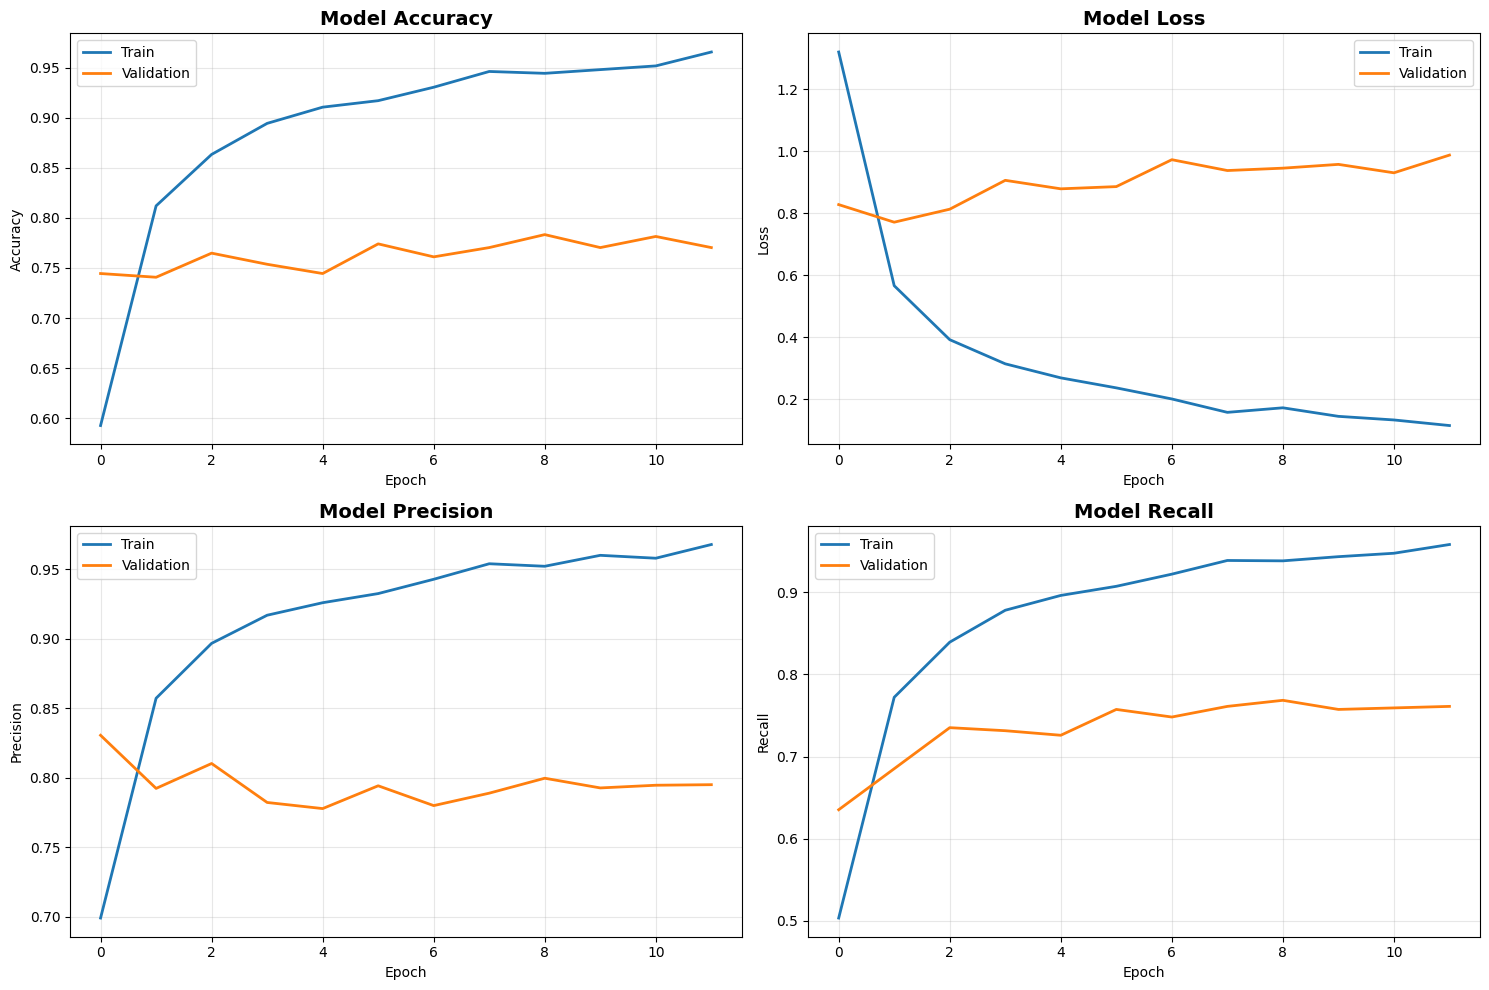

In [12]:
# Plot training history - Enhanced with precision and recall
def plot_training_history(history):
    """
    Plot training and validation metrics (matching food classification style)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
# Evaluate on test set with comprehensive metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nEvaluating on test set...")
test_results = model.evaluate(test_generator)

# Unpack results
test_loss = test_results[0]
test_acc = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calculate F1 score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Accuracy:       {test_acc*100:.2f}%")
print(f"Test Precision:      {test_precision*100:.2f}%")
print(f"Test Recall:         {test_recall*100:.2f}%")
print(f"Test F1-Score:       {test_f1*100:.2f}%")
print(f"Test Loss:           {test_loss:.4f}")
print("="*60)


Evaluating on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 752ms/step - accuracy: 0.9167 - loss: 0.3018 - precision: 0.9456 - recall: 0.8789

TEST SET PERFORMANCE
Test Accuracy:       89.33%
Test Precision:      93.22%
Test Recall:         85.56%
Test F1-Score:       89.22%
Test Loss:           0.3691


In [14]:
# Generate predictions for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nGenerating predictions for test set...")
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)


Generating predictions for test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      aphids       0.90      0.86      0.88        50
    armyworm       0.79      1.00      0.88        50
      beetle       0.94      1.00      0.97        50
    bollworm       0.88      0.86      0.87        50
 grasshopper       0.96      0.96      0.96        50
       mites       0.98      0.82      0.89        50
    mosquito       0.84      0.98      0.91        50
      sawfly       0.83      0.86      0.84        50
  stem_borer       1.00      0.70      0.82        50

    accuracy                           0.89       450
   macro avg       0.90      0.89      0.89       450
weighted avg       0.90      0.89      0.89       450



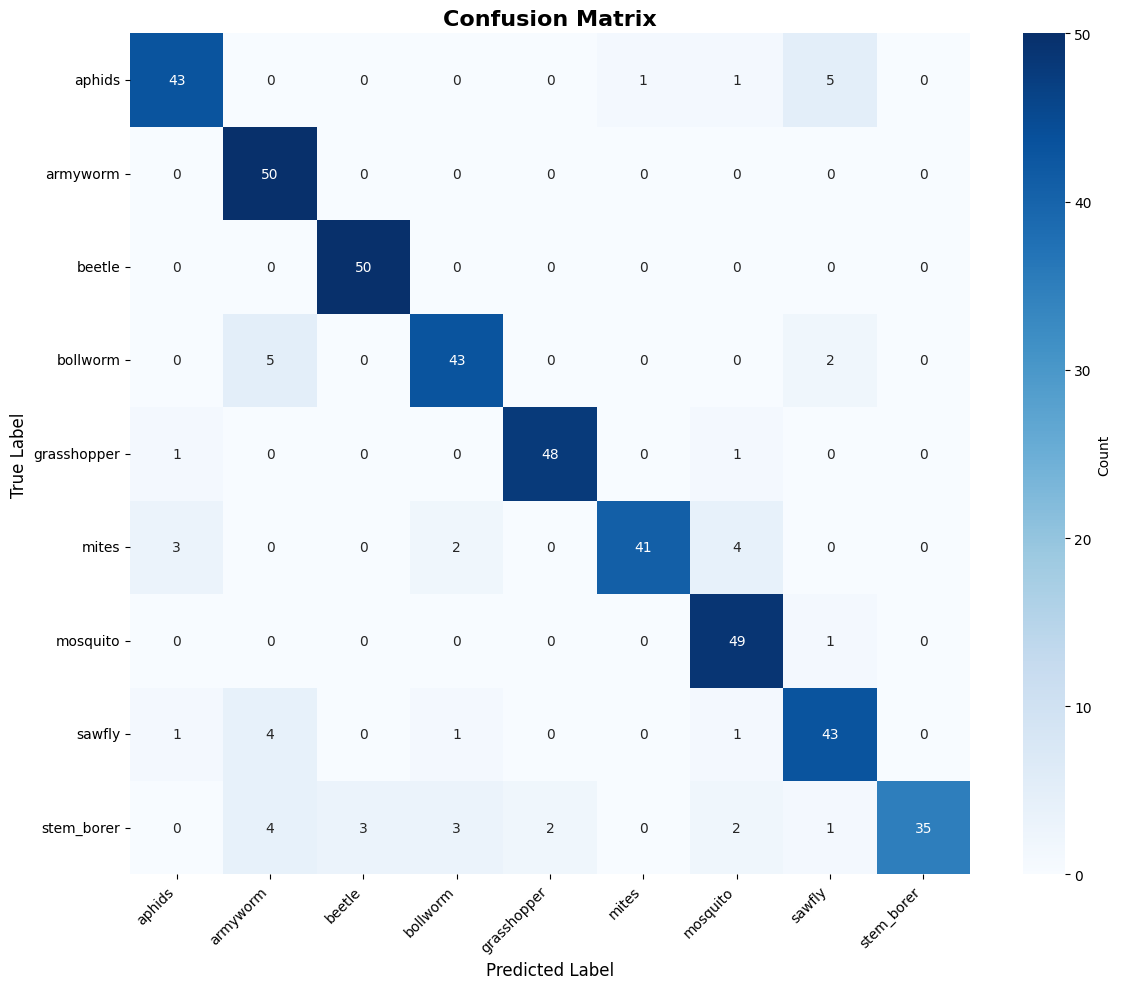

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


PER-CLASS PERFORMANCE
      Class  Precision  Recall  F1-Score  Support
     aphids   0.895833    0.86  0.877551       50
   armyworm   0.793651    1.00  0.884956       50
     beetle   0.943396    1.00  0.970874       50
   bollworm   0.877551    0.86  0.868687       50
grasshopper   0.960000    0.96  0.960000       50
      mites   0.976190    0.82  0.891304       50
   mosquito   0.844828    0.98  0.907407       50
     sawfly   0.826923    0.86  0.843137       50
 stem_borer   1.000000    0.70  0.823529       50


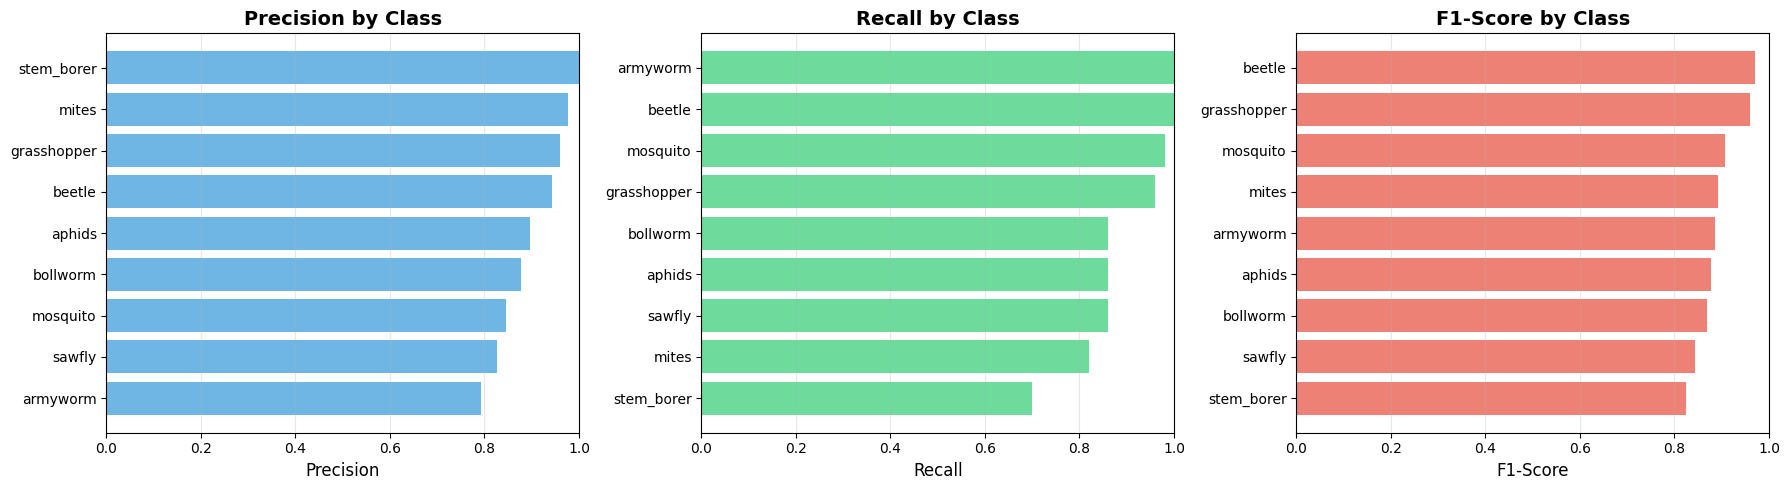


PER-CLASS ACCURACY
aphids              : 86.00%
armyworm            : 100.00%
beetle              : 100.00%
bollworm            : 86.00%
grasshopper         : 96.00%
mites               : 82.00%
mosquito            : 98.00%
sawfly              : 86.00%
stem_borer          : 70.00%


In [16]:
# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Create dataframe
performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    performance_df_sorted = performance_df.sort_values(metric, ascending=True)
    axes[idx].barh(performance_df_sorted['Class'], performance_df_sorted[metric], color=color, alpha=0.7)
    axes[idx].set_xlabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} by Class', fontsize=14, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
cm = confusion_matrix(y_true, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:20s}: {per_class_accuracy[i]*100:.2f}%")
print("="*60)

## 8. Fine-tuning

Fine-tune the model by unfreezing some base layers.

**Fine-tuning Strategy:**
- ✓ Unfreezing last 50 layers for deeper feature adaptation
- ✓ Lower learning rate (1e-5) for stable convergence
- ✓ Standard fine-tuning epochs (20) for optimization
- ✓ Adam optimizer for consistent training
- ✓ Improved callbacks with patience settings

In [17]:
# Fine-tuning configuration - Improved approach
FINE_TUNE_EPOCHS = 20  # Standard fine-tuning epochs
FINE_TUNE_LR = 1e-5    # Lower learning rate for fine-tuning
UNFREEZE_LAYERS = 50   # Unfreeze last 50 layers
FINE_TUNED_MODEL_PATH = os.path.join(MODELS_DIR, 'crop_pest_model_finetuned.h5')

print("\n" + "="*60)
print("FINE-TUNING MODEL")
print("="*60)
print(f"Unfreezing last {UNFREEZE_LAYERS} layers of base model")
print(f"Fine-tuning learning rate: {FINE_TUNE_LR}")
print("="*60 + "\n")

# Unfreeze base model layers
base_model = model.layers[0]  # MobileNetV3 is the first layer in Sequential
base_model.trainable = True

# Count total layers
total_layers = len(base_model.layers)
print(f"Total base model layers: {total_layers}")

# Freeze all except last UNFREEZE_LAYERS
freeze_until = max(0, total_layers - UNFREEZE_LAYERS)
for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

# Count trainable layers
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_count}")
print(f"Frozen layers in base model: {total_layers - trainable_count}\n")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

# Improved callbacks for fine-tuning
fine_tune_callbacks = [
    ModelCheckpoint(
        filepath=FINE_TUNED_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("Starting fine-tuning...")
print(f"Fine-tuning epochs: {FINE_TUNE_EPOCHS}\n")

# Fine-tune
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=fine_tune_callbacks,
    verbose=1
)

print("\n" + "="*60)
print("FINE-TUNING COMPLETED")
print("="*60)


FINE-TUNING MODEL
Unfreezing last 50 layers of base model
Fine-tuning learning rate: 1e-05

Total base model layers: 154
Trainable layers in base model: 50
Frozen layers in base model: 104

Starting fine-tuning...
Fine-tuning epochs: 20

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7323 - loss: 0.8380 - precision: 0.8021 - recall: 0.6753
Epoch 1: val_accuracy improved from -inf to 0.73889, saving model to /content/models/crop_pest_model_finetuned.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 816ms/step - accuracy: 0.7325 - loss: 0.8372 - precision: 0.8021 - recall: 0.6755 - val_accuracy: 0.7389 - val_loss: 0.8589 - val_precision: 0.7946 - val_recall: 0.7093 - learning_rate: 1.0000e-05
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8026 - loss: 0.6104 - precision: 0.8585 - recall: 0.7576
Epoch 2: val_accuracy improved from 0.73889 to 0.74444, saving model to /content/models/crop_pest_model_finetuned.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 0.8025 - loss: 0.6102 - precision: 0.8585 - recall: 0.7575 - val_accuracy: 0.7444 - val_loss: 0.8737 - val_precision: 0.7823 - val_recall: 0.7056 - learning_rate: 1.0000e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7923 - loss: 0.6276 - precision: 0.8437 - recall: 0.7363
Epoch 3: val_accuracy improved from 0.74444 to 0.74630, saving model to /content/models/crop_pest_model_finetuned.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 568ms/step - accuracy: 0.7926 - loss: 0.6271 - precision: 0.8438 - recall: 0.7366 - val_accuracy: 0.7463 - val_loss: 0.9202 - val_precision: 0.7743 - val_recall: 0.7370 - learning_rate: 1.0000e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8124 - loss: 0.5381 - precision: 0.8519 - recall: 0.7712
Epoch 4: val_accuracy improved from 0.74630 to 0.75556, saving model to /content/models/crop_pest_model_finetuned.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 586ms/step - accuracy: 0.8125 - loss: 0.5376 - precision: 0.8521 - recall: 0.7713 - val_accuracy: 0.7556 - val_loss: 0.8695 - val_precision: 0.7897 - val_recall: 0.7370 - learning_rate: 1.0000e-05
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8527 - loss: 0.4712 - precision: 0.8968 - recall: 0.8089
Epoch 5: val_accuracy did not improve from 0.75556
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.8525 - loss: 0.4714 - precision: 0.8967 - recall: 0.8087 - val_accuracy: 0.7333 - val_loss: 0.8759 - val_precision: 0.7793 - val_recall: 0.7259 - learning_rate: 2.0000e-06
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8287 - loss: 0.4636 - precision: 0.8758 - recall: 0.7994
Epoch 6: val_accuracy did not improve from 0.75556
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.8288 - loss: 0.4636 - precision: 0.8758 - recall: 0.7994 - val

68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 507ms/step - accuracy: 0.8515 - loss: 0.4419 - precision: 0.8866 - recall: 0.8303 - val_accuracy: 0.7778 - val_loss: 0.8236 - val_precision: 0.8027 - val_recall: 0.7611 - learning_rate: 2.0000e-06
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8386 - loss: 0.4787 - precision: 0.8745 - recall: 0.8111
Epoch 9: val_accuracy did not improve from 0.77778

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 499ms/step - accuracy: 0.8385 - loss: 0.4787 - precision: 0.8744 - recall: 0.8110 - val_accuracy: 0.7556 - val_loss: 0.8459 - val_precision: 0.7912 - val_recall: 0.7296 - learning_rate: 2.0000e-06
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8581 - loss: 0.4416 - precision: 0.8960 - recall: 0.8182
Epoch 10: val_accuracy did not improve from 0.77778
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 487ms/step - accuracy: 0.8580 - loss: 0.4415 - precision: 0.8959 - recall: 0.8181 - va


Epoch 14: ReduceLROnPlateau reducing learning rate to 8.00000009348878e-08.
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 503ms/step - accuracy: 0.8489 - loss: 0.4310 - precision: 0.8956 - recall: 0.8228 - val_accuracy: 0.7796 - val_loss: 0.7924 - val_precision: 0.8056 - val_recall: 0.7444 - learning_rate: 4.0000e-07
Epoch 15/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8596 - loss: 0.4270 - precision: 0.9041 - recall: 0.8260
Epoch 15: val_accuracy did not improve from 0.77963
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 511ms/step - accuracy: 0.8595 - loss: 0.4270 - precision: 0.9040 - recall: 0.8259 - val_accuracy: 0.7537 - val_loss: 0.8051 - val_precision: 0.7971 - val_recall: 0.7204 - learning_rate: 8.0000e-08
Epoch 16/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8392 - loss: 0.4278 - precision: 0.8799 - recall: 0.8143
Epoch 16: val_accuracy did not improve from 0.77963
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 488ms/step - accuracy: 0.8393 - loss: 0.4278 - precision: 0.8800 - recall: 0.8144 - 


Evaluating fine-tuned model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9289 - loss: 0.1945 - precision: 0.9543 - recall: 0.9138

FINE-TUNED MODEL PERFORMANCE COMPARISON
Test Accuracy:       91.56% (was 89.33%) | Δ: +2.22%
Test Precision:      93.12% (was 93.22%) | Δ: -0.10%
Test Recall:         90.22% (was 85.56%) | Δ: +4.67%
Test F1-Score:       91.65% (was 89.22%) | Δ: +2.42%
Test Loss:           0.2744 (was 0.3691) | Δ: -0.0947


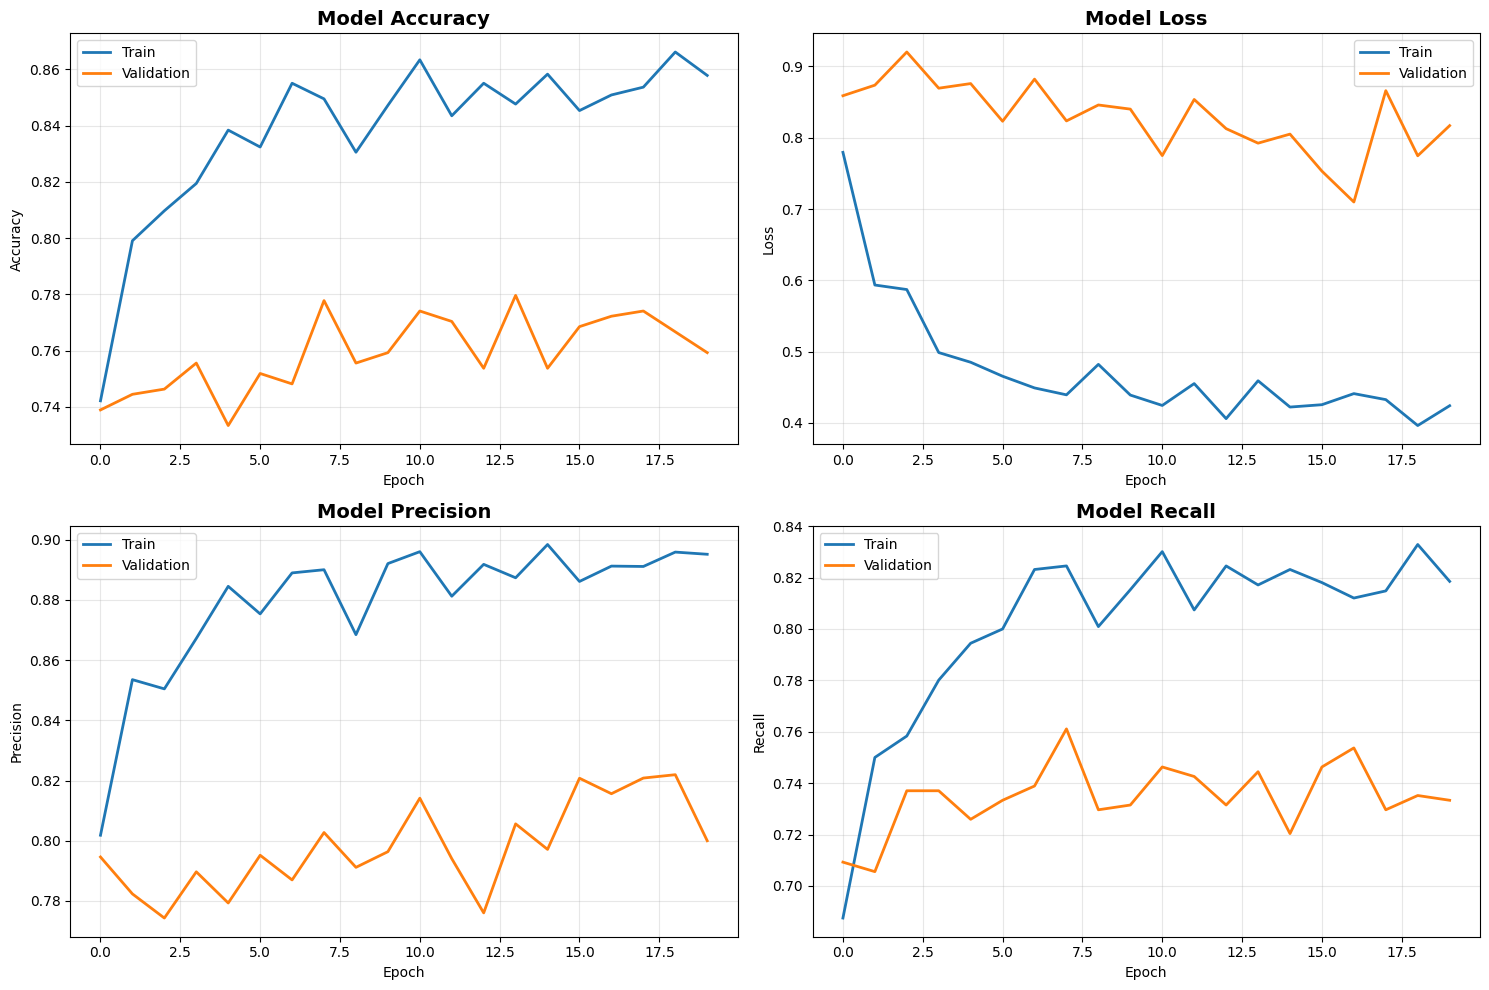

In [18]:
# Evaluate fine-tuned model
print("\nEvaluating fine-tuned model on test set...")
test_results_ft = model.evaluate(test_generator)

# Unpack fine-tuned results
test_loss_ft = test_results_ft[0]
test_acc_ft = test_results_ft[1]
test_precision_ft = test_results_ft[2]
test_recall_ft = test_results_ft[3]

# Calculate F1 score
test_f1_ft = 2 * (test_precision_ft * test_recall_ft) / (test_precision_ft + test_recall_ft + 1e-7)

print("\n" + "="*70)
print("FINE-TUNED MODEL PERFORMANCE COMPARISON")
print("="*70)
print(f"Test Accuracy:       {test_acc_ft*100:.2f}% (was {test_acc*100:.2f}%) | Δ: {(test_acc_ft-test_acc)*100:+.2f}%")
print(f"Test Precision:      {test_precision_ft*100:.2f}% (was {test_precision*100:.2f}%) | Δ: {(test_precision_ft-test_precision)*100:+.2f}%")
print(f"Test Recall:         {test_recall_ft*100:.2f}% (was {test_recall*100:.2f}%) | Δ: {(test_recall_ft-test_recall)*100:+.2f}%")
print(f"Test F1-Score:       {test_f1_ft*100:.2f}% (was {test_f1*100:.2f}%) | Δ: {(test_f1_ft-test_f1)*100:+.2f}%")
print(f"Test Loss:           {test_loss_ft:.4f} (was {test_loss:.4f}) | Δ: {(test_loss_ft-test_loss):+.4f}")
print("="*70)

# Plot fine-tuning history
plot_training_history(history_fine)


Generating predictions for fine-tuned model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step


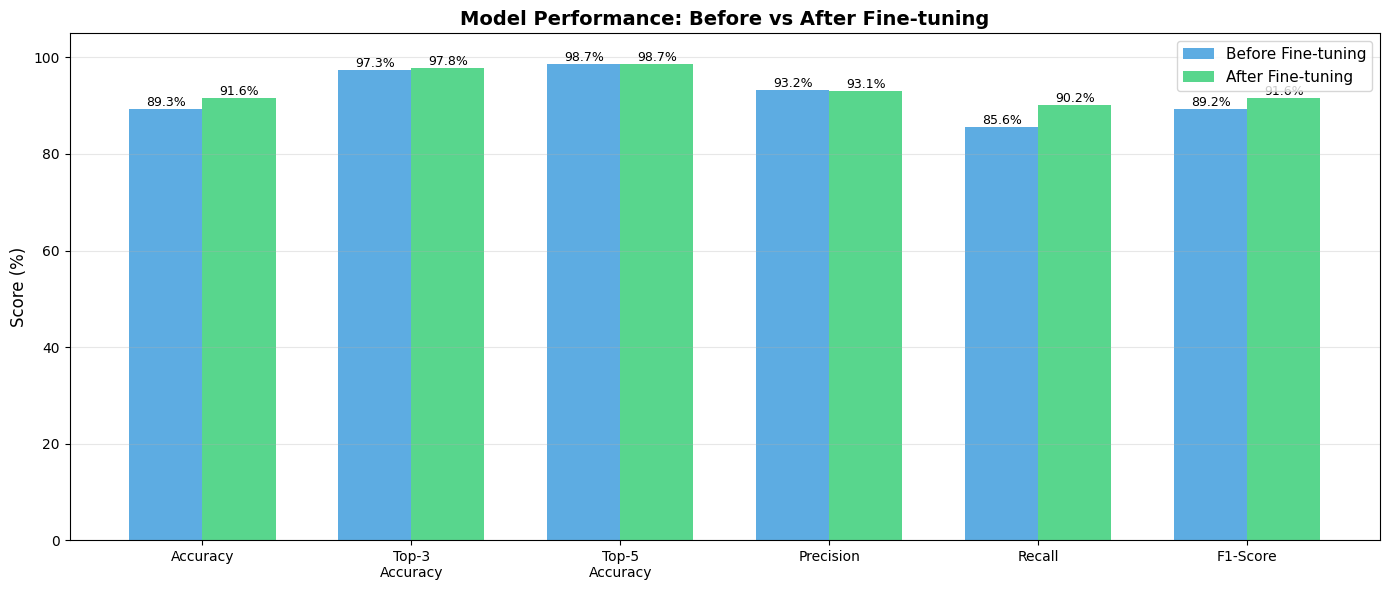


IMPROVEMENT SUMMARY
Accuracy       :  +2.22% ✓ Improved
Top-3
Accuracy :  +0.44% ✓ Improved
Top-5
Accuracy :  +0.00% ⚠ Decreased
Precision      :  -0.10% ⚠ Decreased
Recall         :  +4.67% ✓ Improved
F1-Score       :  +2.42% ✓ Improved


In [20]:
# Performance improvement summary
import matplotlib.pyplot as plt

# Calculate Top-K accuracies for the initial model (before fine-tuning)
# Ensure test_generator is reset for consistent prediction order if needed, but here we use existing `predictions` and `y_true`
# `predictions` and `y_true` were generated from the initial model in cell `96fb6d1d`
test_top3 = np.mean([1 if y_true[i] in np.argsort(predictions[i])[-3:] else 0 for i in range(len(y_true))])
test_top5 = np.mean([1 if y_true[i] in np.argsort(predictions[i])[-5:] else 0 for i in range(len(y_true))])

# Calculate Top-K accuracies for the fine-tuned model
# The `model` variable currently holds the fine-tuned model due to restore_best_weights=True
print("\nGenerating predictions for fine-tuned model on test set...")
test_generator.reset()
predictions_ft = model.predict(test_generator, verbose=1)

test_top3_ft = np.mean([1 if y_true[i] in np.argsort(predictions_ft[i])[-3:] else 0 for i in range(len(y_true))])
test_top5_ft = np.mean([1 if y_true[i] in np.argsort(predictions_ft[i])[-5:] else 0 for i in range(len(y_true))])

# Create comparison visualization
metrics = ['Accuracy', 'Top-3\nAccuracy', 'Top-5\nAccuracy', 'Precision', 'Recall', 'F1-Score']
before_values = [test_acc*100, test_top3*100, test_top5*100, test_precision*100, test_recall*100, test_f1*100]
after_values = [test_acc_ft*100, test_top3_ft*100, test_top5_ft*100, test_precision_ft*100, test_recall_ft*100, test_f1_ft*100]

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, before_values, width, label='Before Fine-tuning', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, after_values, width, label='After Fine-tuning', alpha=0.8, color='#2ecc71')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Model Performance: Before vs After Fine-tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print improvement summary
print("\n" + "="*60)
print("IMPROVEMENT SUMMARY")
print("="*60)
improvements = [
    (test_acc_ft - test_acc) * 100,
    (test_top3_ft - test_top3) * 100,
    (test_top5_ft - test_top5) * 100,
    (test_precision_ft - test_precision) * 100,
    (test_recall_ft - test_recall) * 100,
    (test_f1_ft - test_f1) * 100
]

for metric, improvement in zip(metrics, improvements):
    status = "✓ Improved" if improvement > 0 else "⚠ Decreased"
    print(f"{metric:15s}: {improvement:+6.2f}% {status}")
print("="*60)

## 8. Model Interpretability and Prediction Analysis

Analyze prediction confidence and model behavior.

Analyzing prediction confidence across test set...


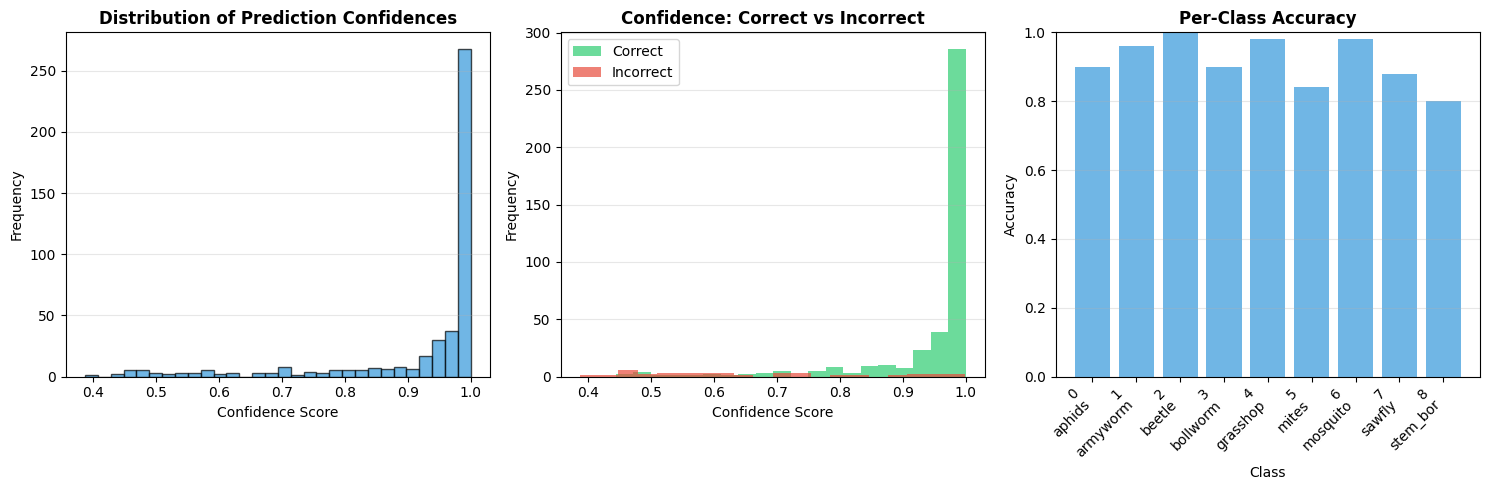


CONFIDENCE ANALYSIS SUMMARY
Overall accuracy on sample: 91.56%
Average confidence: 92.59%
Avg confidence (correct):   95.15%
Avg confidence (incorrect): 64.91%
Total samples analyzed: 450


In [21]:
# Confidence distribution analysis
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

all_predictions = []
all_confidences = []
all_true_labels = []

print("Analyzing prediction confidence across test set...")

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(TEST_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    # Sample up to 50 images per class for analysis
    for img_file in image_files[:50]:
        img_path = os.path.join(class_path, img_file)

        # Load and preprocess image
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(np.expand_dims(img_array, axis=0))

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        confidence = np.max(prediction)
        predicted_class_idx = np.argmax(prediction)

        all_predictions.append(predicted_class_idx)
        all_confidences.append(confidence)
        all_true_labels.append(class_idx)

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_confidences = np.array(all_confidences)
all_true_labels = np.array(all_true_labels)

# Identify correct vs incorrect predictions
correct_predictions = all_predictions == all_true_labels
correct_confidences = all_confidences[correct_predictions]
incorrect_confidences = all_confidences[~correct_predictions]

# Visualization
plt.figure(figsize=(15, 5))

# Overall confidence distribution
plt.subplot(1, 3, 1)
plt.hist(all_confidences, bins=30, alpha=0.7, edgecolor='black', color='#3498db')
plt.title('Distribution of Prediction Confidences', fontsize=12, fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

# Correct vs Incorrect predictions
plt.subplot(1, 3, 2)
plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='#2ecc71')
plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='#e74c3c')
plt.title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Per-class accuracy
plt.subplot(1, 3, 3)
class_accuracies = []
for i in range(len(class_names)):
    class_mask = all_true_labels == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(all_predictions[class_mask] == all_true_labels[class_mask])
        class_accuracies.append(class_accuracy)
    else:
        class_accuracies.append(0)

plt.bar(range(len(class_names)), class_accuracies, color='#3498db', alpha=0.7)
plt.title('Per-Class Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(len(class_names)), [f'{i}\n{class_names[i][:8]}' for i in range(len(class_names))], rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("CONFIDENCE ANALYSIS SUMMARY")
print("="*60)
print(f"Overall accuracy on sample: {np.mean(all_predictions == all_true_labels)*100:.2f}%")
print(f"Average confidence: {np.mean(all_confidences)*100:.2f}%")
if len(correct_confidences) > 0:
    print(f"Avg confidence (correct):   {np.mean(correct_confidences)*100:.2f}%")
if len(incorrect_confidences) > 0:
    print(f"Avg confidence (incorrect): {np.mean(incorrect_confidences)*100:.2f}%")
print(f"Total samples analyzed: {len(all_predictions)}")
print("="*60)

Analyzing sample predictions from each class...


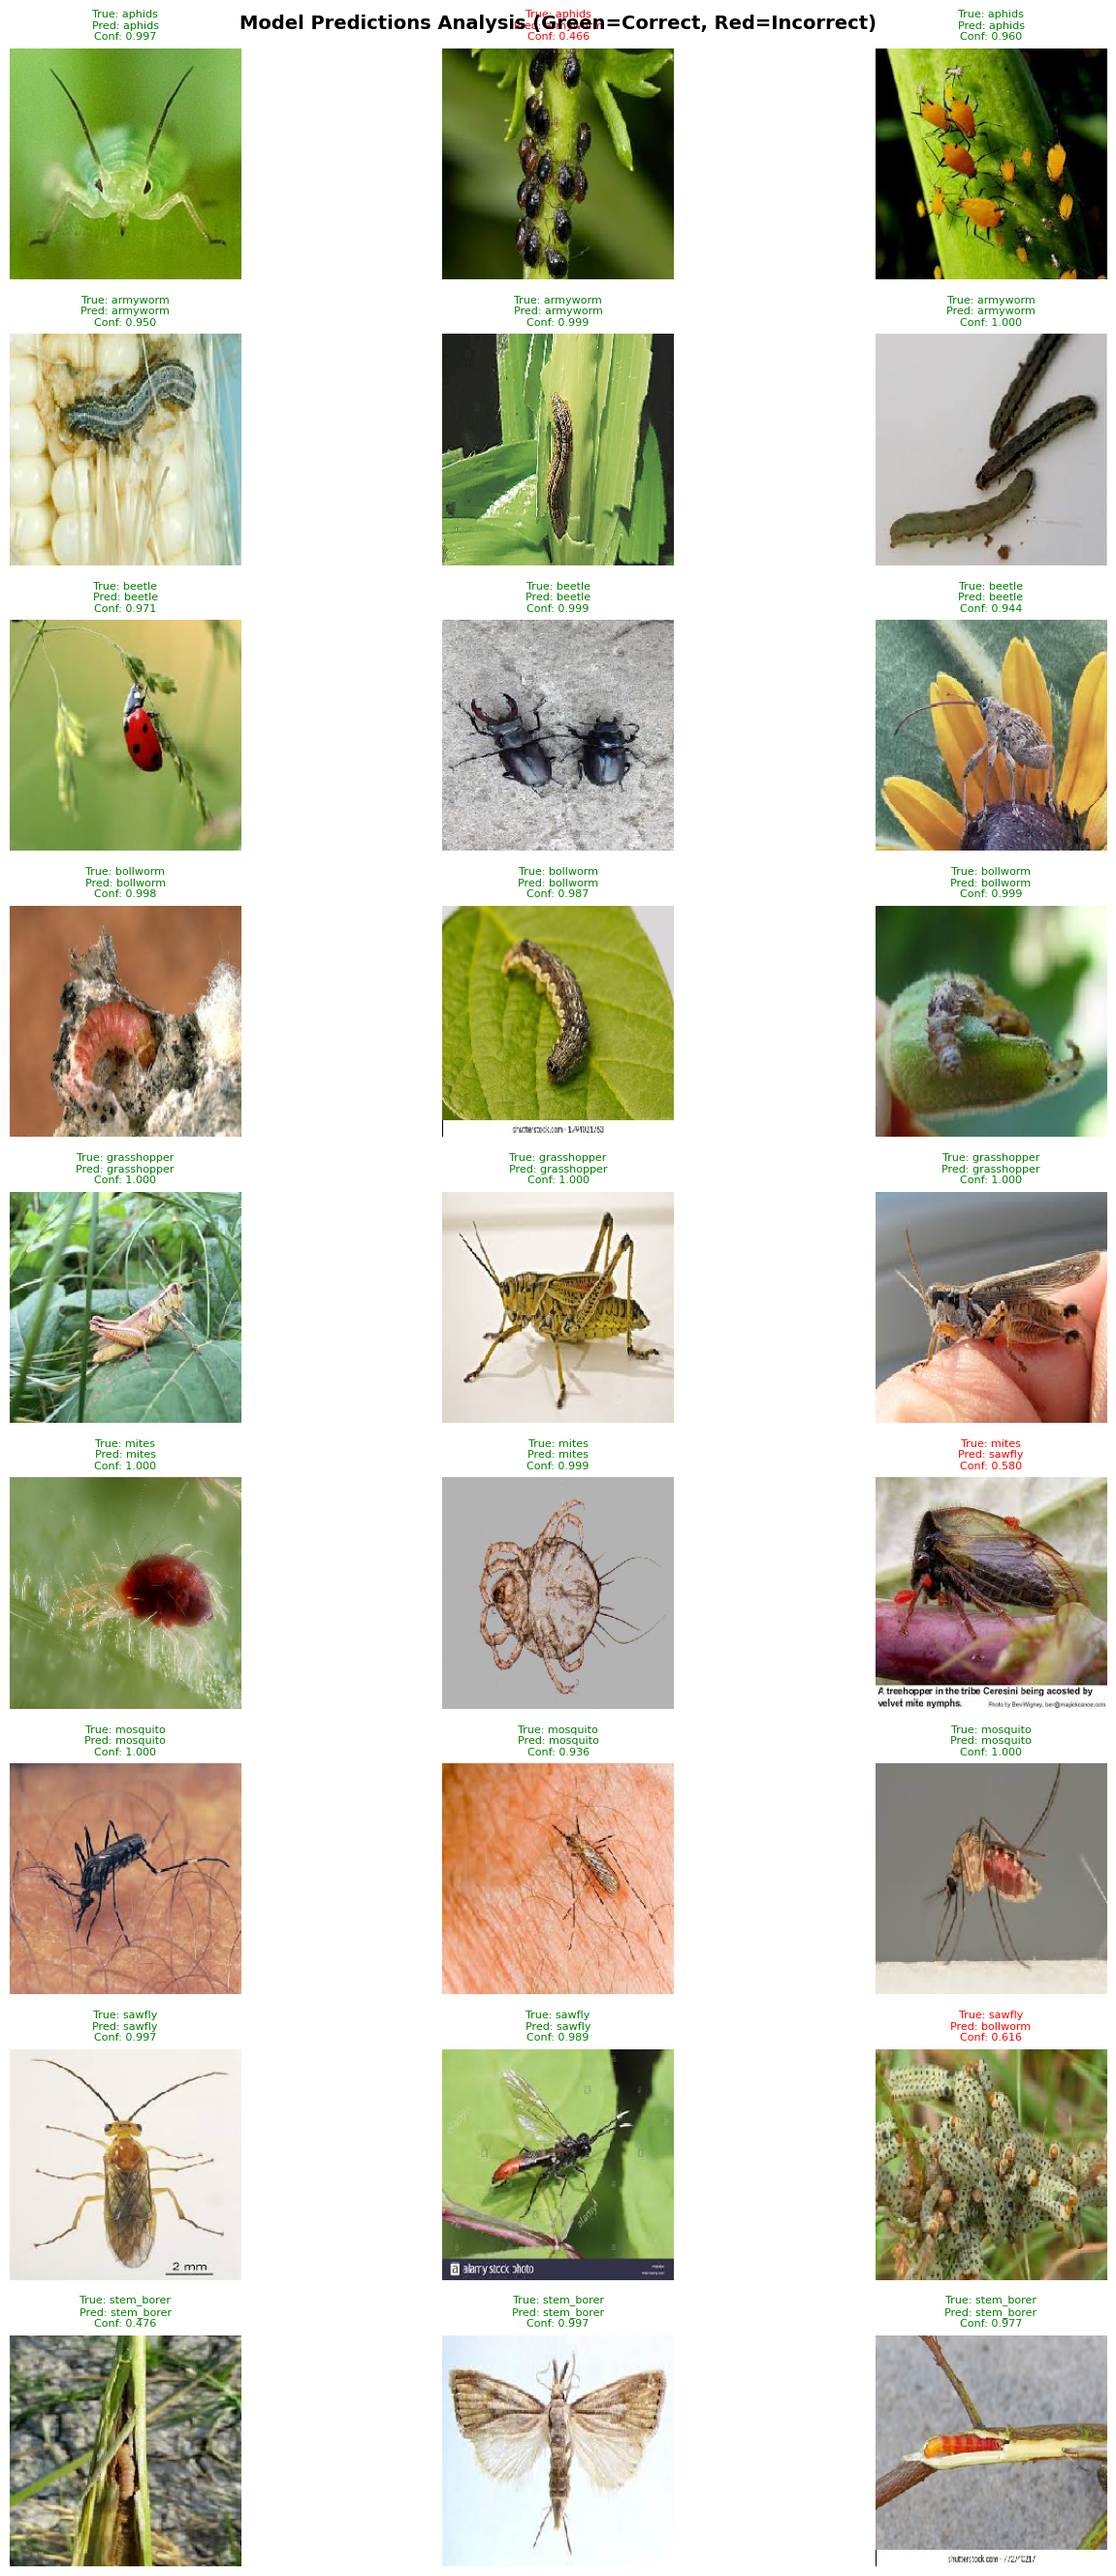

In [22]:
# Analyze predictions with visual feedback
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def analyze_predictions_visual(model, data_dir, classes, num_samples=3):
    """
    Analyze model predictions with visual feedback showing correct/incorrect predictions.
    Green border = Correct prediction, Red border = Incorrect prediction
    """
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        for j in range(min(num_samples, len(image_files))):
            img_path = os.path.join(class_path, image_files[j])

            # Load and preprocess image
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = preprocess_input(np.expand_dims(img_array, axis=0))

            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            predicted_class_idx = np.argmax(prediction)
            confidence = np.max(prediction)
            predicted_class = classes[predicted_class_idx]

            # Determine if prediction is correct
            is_correct = predicted_class == class_name
            color = 'green' if is_correct else 'red'

            # Plot image with prediction
            if len(classes) == 1:
                axes[j].imshow(img)
                axes[j].set_title(f"True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.3f}",
                                color=color, fontsize=9)
                axes[j].axis('off')
            else:
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.3f}",
                                    color=color, fontsize=8)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_ylabel(class_name, fontsize=10, fontweight='bold')

    plt.suptitle('Model Predictions Analysis (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Analyzing sample predictions from each class...")
analyze_predictions_visual(model, TEST_DIR, class_names, num_samples=3)

In [23]:
# Test Time Augmentation (TTA) for improved predictions
# This creates multiple augmented versions of each image and averages predictions

def predict_with_tta(model, test_gen, num_augmentations=5):
    """
    Perform Test Time Augmentation for more robust predictions.

    Args:
        model: Trained model
        test_gen: Test data generator
        num_augmentations: Number of augmented predictions to average

    Returns:
        Averaged predictions
    """
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

    # Create TTA generator with light augmentations
    tta_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    all_predictions = []

    # Get original predictions
    print("Getting original predictions...")
    test_gen.reset()
    original_preds = model.predict(test_gen, verbose=1)
    all_predictions.append(original_preds)

    # Get augmented predictions
    print(f"\nApplying {num_augmentations} augmentations...")
    for i in range(num_augmentations):
        print(f"Augmentation {i+1}/{num_augmentations}...")

        # Create augmented generator
        aug_gen = tta_datagen.flow_from_directory(
            TEST_DIR,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        # Predict
        aug_preds = model.predict(aug_gen, verbose=0)
        all_predictions.append(aug_preds)

    # Average all predictions
    final_predictions = np.mean(all_predictions, axis=0)

    return final_predictions

# Apply TTA (optional - comment out if you want to skip)
print("\n" + "="*60)
print("APPLYING TEST TIME AUGMENTATION")
print("="*60)
print("This will improve accuracy but takes longer to run...")

tta_predictions = predict_with_tta(model, test_generator, num_augmentations=5)
y_pred_tta = np.argmax(tta_predictions, axis=1)
y_true_tta = test_generator.classes

# Calculate TTA accuracy
tta_accuracy = np.mean(y_pred_tta == y_true_tta)
tta_top3_accuracy = np.mean([1 if y_true_tta[i] in np.argsort(tta_predictions[i])[-3:] else 0 for i in range(len(y_true_tta))])
tta_top5_accuracy = np.mean([1 if y_true_tta[i] in np.argsort(tta_predictions[i])[-5:] else 0 for i in range(len(y_true_tta))])

# Calculate precision, recall, F1
from sklearn.metrics import precision_recall_fscore_support
tta_precision, tta_recall, tta_f1, _ = precision_recall_fscore_support(y_true_tta, y_pred_tta, average='weighted', zero_division=0)

print("\n" + "="*70)
print("TEST TIME AUGMENTATION RESULTS")
print("="*70)
print(f"TTA Accuracy:       {tta_accuracy*100:.2f}% (was {test_acc_ft*100:.2f}%) | Δ: {(tta_accuracy-test_acc_ft)*100:+.2f}%")
print(f"TTA Top-3 Accuracy: {tta_top3_accuracy*100:.2f}%")
print(f"TTA Top-5 Accuracy: {tta_top5_accuracy*100:.2f}%")
print(f"TTA Precision:      {tta_precision*100:.2f}% (was {test_precision_ft*100:.2f}%) | Δ: {(tta_precision-test_precision_ft)*100:+.2f}%")
print(f"TTA Recall:         {tta_recall*100:.2f}% (was {test_recall_ft*100:.2f}%) | Δ: {(tta_recall-test_recall_ft)*100:+.2f}%")
print(f"TTA F1-Score:       {tta_f1*100:.2f}% (was {test_f1_ft*100:.2f}%) | Δ: {(tta_f1-test_f1_ft)*100:+.2f}%")
print("="*70)

print("\n✓ Test Time Augmentation typically improves accuracy by 1-3%")


APPLYING TEST TIME AUGMENTATION
This will improve accuracy but takes longer to run...
Getting original predictions...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Applying 5 augmentations...
Augmentation 1/5...
Found 450 images belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Augmentation 2/5...
Found 450 images belonging to 9 classes.
Augmentation 3/5...
Found 450 images belonging to 9 classes.
Augmentation 4/5...
Found 450 images belonging to 9 classes.
Augmentation 5/5...
Found 450 images belonging to 9 classes.

TEST TIME AUGMENTATION RESULTS
TTA Accuracy:       93.33% (was 91.56%) | Δ: +1.78%
TTA Top-3 Accuracy: 97.78%
TTA Top-5 Accuracy: 98.89%
TTA Precision:      93.73% (was 93.12%) | Δ: +0.61%
TTA Recall:         93.33% (was 90.22%) | Δ: +3.11%
TTA F1-Score:       93.30% (was 91.65%) | Δ: +1.65%

✓ Test Time Augmentation typically improves accuracy by 1-3%


## 9. Save Model and Export

Save the final model for download and deployment.

## 10. Sample Prediction

Test the model with a sample prediction.

In [24]:
import json
from datetime import datetime

# Save class names
class_names_path = os.path.join(MODELS_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"✓ Class names saved to: {class_names_path}")

# Save comprehensive model metadata
metadata = {
    "model_name": "Crop Pest Detection CNN",
    "created_date": datetime.now().isoformat(),
    "classes": class_names,
    "num_classes": num_classes,
    "input_shape": list(IMG_SIZE) + [3],
    "architecture": "MobileNetV2 with Transfer Learning",
    "framework": "TensorFlow/Keras",
    "training_params": {
        "initial_epochs": EPOCHS,
        "fine_tune_epochs": FINE_TUNE_EPOCHS,
        "batch_size": BATCH_SIZE,
        "initial_lr": LEARNING_RATE,
        "fine_tune_lr": FINE_TUNE_LR,
        "unfrozen_layers": UNFREEZE_LAYERS,
        "optimizer": "Adam",
        "validation_split": 0.2
    },
    "architecture_details": {
        "base_model": "MobileNetV2",
        "dense_layers": [512, 256],
        "dropout_rates": [0.5, 0.3, 0.2],
        "batch_normalization": True,
        "global_pooling": "GlobalAveragePooling2D"
    },
    "performance": {
        "test_accuracy": float(test_acc_ft),
        "test_precision": float(test_precision_ft),
        "test_recall": float(test_recall_ft),
        "test_f1_score": float(test_f1_ft),
        "test_loss": float(test_loss_ft)
    },
    "improvements": {
        "accuracy_gain": float((test_acc_ft - test_acc) * 100),
        "precision_gain": float((test_precision_ft - test_precision) * 100),
        "recall_gain": float((test_recall_ft - test_recall) * 100),
        "f1_score_gain": float((test_f1_ft - test_f1) * 100)
    }
}

metadata_path = os.path.join(MODELS_DIR, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

# Save model summary
summary_path = os.path.join(MODELS_DIR, 'model_summary.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"✓ Model summary saved to: {summary_path}")

print("\n" + "="*60)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"\nModel files:")
print(f"  - Initial model: {MODEL_SAVE_PATH}")
print(f"  - Fine-tuned model: {FINE_TUNED_MODEL_PATH}")
print(f"  - Class names: {class_names_path}")
print(f"  - Metadata: {metadata_path}")
print(f"  - Model summary: {summary_path}")
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"  - Accuracy:  {test_acc_ft*100:.2f}%")
print(f"  - Precision: {test_precision_ft*100:.2f}%")
print(f"  - Recall:    {test_recall_ft*100:.2f}%")
print(f"  - F1-Score:  {test_f1_ft*100:.2f}%")
print("="*60)

✓ Class names saved to: /content/models/class_names.json
✓ Model metadata saved to: /content/models/model_metadata.json


✓ Model summary saved to: /content/models/model_summary.txt

ALL FILES SAVED SUCCESSFULLY

Model files:
  - Initial model: /content/models/crop_pest_model.h5
  - Fine-tuned model: /content/models/crop_pest_model_finetuned.h5
  - Class names: /content/models/class_names.json
  - Metadata: /content/models/model_metadata.json
  - Model summary: /content/models/model_summary.txt

FINAL MODEL PERFORMANCE
  - Accuracy:  91.56%
  - Precision: 93.12%
  - Recall:    90.22%
  - F1-Score:  91.65%



Testing with image from class: bollworm
Image path: /root/.cache/kagglehub/datasets/simranvolunesia/pest-dataset/versions/1/pest/test/bollworm/jpg_39.jpg



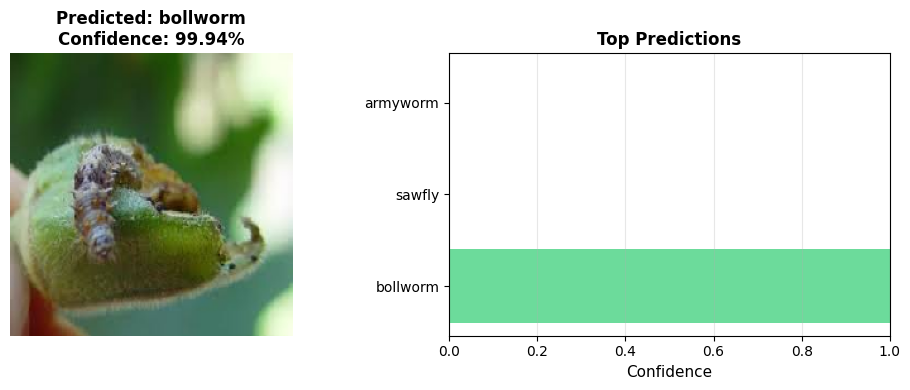


Prediction Results:
  1. bollworm             -  99.94%
  2. sawfly               -   0.03%
  3. armyworm             -   0.02%


In [25]:
# Sample prediction on a test image with improved visualization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_image(model, image_path, class_names, top_k=3):
    """
    Predict pest class for a single image (matching food classification style).
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array, verbose=0)

    # Get top K predictions
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_probs = predictions[0][top_indices]

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[top_indices[0]]}\nConfidence: {top_probs[0]*100:.2f}%",
             fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(top_k)]
    plt.barh([class_names[i] for i in top_indices], top_probs, color=colors, alpha=0.7)
    plt.xlabel('Confidence', fontsize=11)
    plt.title('Top Predictions', fontsize=12, fontweight='bold')
    plt.xlim([0, 1])
    plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nPrediction Results:")
    for i, (idx, prob) in enumerate(zip(top_indices, top_probs), 1):
        print(f"  {i}. {class_names[idx]:20s} - {prob*100:6.2f}%")

# Get a random test image
import random
test_class = random.choice(class_names)
test_class_dir = os.path.join(TEST_DIR, test_class)
test_images = [f for f in os.listdir(test_class_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

if test_images:
    sample_image = os.path.join(test_class_dir, random.choice(test_images))
    print(f"\nTesting with image from class: {test_class}")
    print(f"Image path: {sample_image}\n")
    predict_image(model, sample_image, class_names)
else:
    print("No test images available for prediction demo")